### Graph transformation history

In [1]:
import nographs as nog
from graphviz import Digraph
import functools
import inspect

In [2]:
dict_1= {0:{1,2}, 1:{2,0}, 2:{0,1}, }
dict_2= {0:{1,}, 1:{2,3}, 2:{4,}, 3:{}, 4:{} }

def forward(x, _):
    return dict_1[x]

In [3]:
# https://www.graphviz.org/doc/info/attrs.html
node_style =dict( style='filled', shape='box', 
                                align='left',
                                fontsize='12',
                                ranksep='0.01',
                                height='0.02',width='0.04',)
gr_style = dict( linelength="16",rankdir='LR',size='16,8',layout="neato")#landscape="True",splines='curved' 

def adapter_graphviz( wrapped ):
    dot = Digraph( node_attr = node_style, graph_attr = gr_style, )
    @functools.wraps( wrapped )
    def wrapper_bg( x, t ):
        node = dot.node( str(hash(x)), str(x) )
        for result in wrapped(x, t):
            dot.edge( str(hash( x )), str(hash( result )), )# label=f"{str(x)}-{str(result)}",
            yield result
    wrapper_bg.dot = dot
    return wrapper_bg
    

In [4]:
class EdgeSplitter:
    def __init__(self, wrapped):
        self.in_history = True
        functools.update_wrapper(self, wrapped )
        self.newbies = set()
    def __call__(self, x, t):

        if x in self.newbies:
            yield x[1]
        else:
            for result in self.__wrapped__(x, t):
                # creating new vertex at the middle of edge, new id is tuple of edge's ends
                self.newbies.add((x, result))
                yield (x, result)



In [5]:
import ast
class NameMod:
    def __init__(self, wrapped):
        self.in_history = False
        functools.update_wrapper(self, wrapped )
    def __call__(self, x, t):
        #print(x, ast.literal_eval(x),type(ast.literal_eval(x)) )
        for result in self.__wrapped__( ast.literal_eval(x[1:-1]), t):
            #print("---",result,type(result) )
            yield f"-{result}-"

In [6]:
@adapter_graphviz
@NameMod
@EdgeSplitter
def stringy(x, _):
    #print("===",x,type(x) )
    return dict_1[x]
    
trav_forward = nog.TraversalBreadthFirst( stringy )
trav_forward.start_from( "-0-", build_paths=True )
str( list(trav_forward) )
0

0

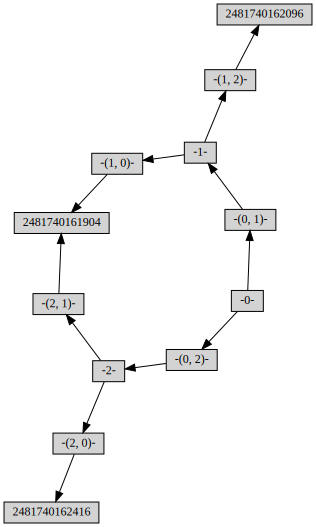

In [7]:
#print(double_splitted.dot.source)
stringy.dot

In [8]:
def wrg( f, _ ):
    print(f, hasattr(f,"in_history"))
    if hasattr( f, "__wrapped__" ):
        return (f.__wrapped__,)
    return ()

trav_forward = nog.TraversalBreadthFirst( wrg )
trav_forward.start_from( stringy, build_paths=True )
str( list(trav_forward) )

<function stringy at 0x00000241D33D41F0> True
<__main__.NameMod object at 0x00000241D33CCD30> True
<__main__.EdgeSplitter object at 0x00000241D33CC8E0> True
<function stringy at 0x00000241D33D4160> False


'[<__main__.NameMod object at 0x00000241D33CCD30>, <__main__.EdgeSplitter object at 0x00000241D33CC8E0>, <function stringy at 0x00000241D33D4160>]'

In [9]:
x='1'
print(x, ast.literal_eval(x),type(ast.literal_eval(x)) )

1 1 <class 'int'>


In [10]:
class GraphMorph:
    def __init__(self, wrapped):
        functools.update_wrapper(self, wrapped )
    def __call__(self, x, t):
        yield from self.__wrapped__( x, t )

class GraphMorphWrapNodes(GraphMorph):
    def __init__(self,*argc,**argv):
        super().__init__(*argc,**argv)
    def __call__(self, x, t):
        new_x = (self, x)
        yield from self.__wrapped__( x, t )



In [11]:
class FreeForget(GraphMorph):  # All possible paths
    def __init__(self,*argc,**argv):
        super().__init__(*argc,**argv)
    def __call__(self, x, t):
        yield x # identity morphism
        for ch1 in self.__wrapped__( x, t ):
            yield from self.__call__(ch1, t)
    def node_label( x ):
        return str(x)
    def node_id( x ):
        return str(hash(x))
        

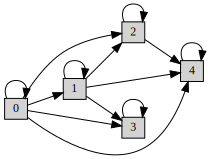

In [12]:
@adapter_graphviz
#@EdgeSplitter
@FreeForget
def cat(x, _):
    return dict_2[x]
    
trav_forward = nog.TraversalBreadthFirst( cat )
trav_forward.start_from( 0, )
str( list(trav_forward) )
cat.dot.graph_attr['layout']='dot'
cat.dot

In [13]:
print(stringy.dot.source)

digraph {
	graph [layout=neato linelength=16 rankdir=LR size="16,8"]
	node [align=left fontsize=12 height=0.02 ranksep=0.01 shape=box style=filled width=0.04]
	2481740099824 [label="-0-"]
	2481740099824 -> 2481740161776
	2481740099824 -> 2481740161584
	2481740161776 [label="-(0, 1)-"]
	2481740161776 -> 2481740161456
	2481740161584 [label="-(0, 2)-"]
	2481740161584 -> 2481740161648
	2481740161456 [label="-1-"]
	2481740161456 -> 2481740162160
	2481740161456 -> 2481740162224
	2481740161648 [label="-2-"]
	2481740161648 -> 2481740161968
	2481740161648 -> 2481740162288
	2481740162160 [label="-(1, 0)-"]
	2481740162160 -> 2481740161904
	2481740162224 [label="-(1, 2)-"]
	2481740162224 -> 2481740162096
	2481740161968 [label="-(2, 0)-"]
	2481740161968 -> 2481740162416
	2481740162288 [label="-(2, 1)-"]
	2481740162288 -> 2481740161904
}

